In [1]:
from IPython.display import Image 

# Step 1: Browse the Ocean Marketplace Using the App

To work with Ocean Protocol you need to set up a digital wallet. First, create a metamask account. There are many guides for doing this available online (e.g. [here](https://docs.oceanprotocol.com/tutorials/metamask-setup/)). Switch from the Ethereum Mainnet to the Rinkeby Test Network from your MetaMask wallet. Rinkeby is where you can test with no real transaction fees. Instead we use Rinkeby tokens that can be requested from faucets. Ocean tokens are needed to purchase datasets on the Ocean Marketplace. You can request Rinkeby Ocean from the Ocean faucet [here](https://faucet.rinkeby.oceanprotocol.com/). Making transactions on Ocean Marketplace (e.g. purchasing a dataset) also costs gas in ETH. We can request Rinkeby ETH from the faucet [here](https://faucets.chain.link/rinkeby). 

Now that we have some Rinkeby Ocean and ETH in our wallet, we can browse and purchase datasets on the [Ocean Marketplace](https://market.oceanprotocol.com/). When you enter a Web3 app in the browser you may need to sign in with your wallet. Make sure that you are browsing datasets on the Rinkeby network (see image below). 

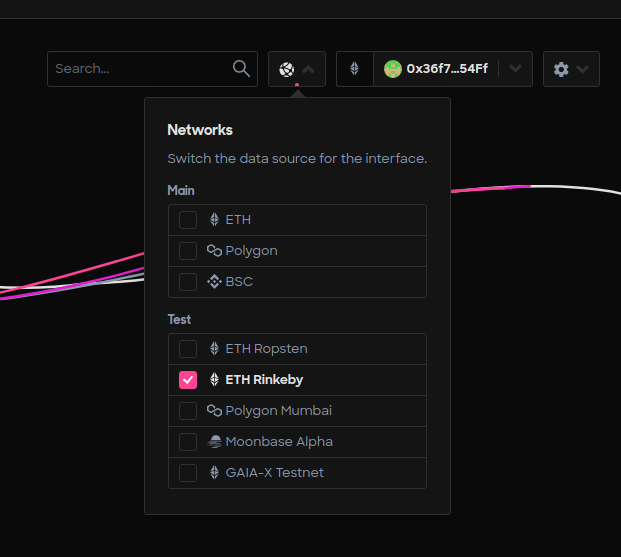

In [2]:
display(Image(filename='images/marketplace-network.png', width = 400))

We will be working with a BCI dataset. You can find more information about the dataset [here](https://phas3.notion.site/EEG-dataset-details-680893f310d54fcaa85deb8b02f59c03). While the dataset is freely available online, we have uploaded it as a private dataset to practice the workflow. In future, we hope that the use of private datasets with BCI algorithms opens up new use cases. You can see the dataset on the Ocean marketplace [here](https://market.oceanprotocol.com/asset/did:op:3819B03ADeaBE19e14b8e514544Ba1a6E61ea510). 

In the traditional data science workflow, a data scientist downloads a dataset locally before running their code on it. In this scenario, the data comes to the code running on it. In contrast, private datasets on the marketplace cannot be downloaded. Instead, a data scientist can send code to the data itself where it runs the computations before returning the results. This is called Compute-to-Data (C2D), which is similar to Federated Learning. On the Ocean Marketplace, data providers should provide a sample of the data to give an idea of the quality of the data as well as the data interface through which it can be accessed. 

Download the sample data for the BCI dataset through the Marketplace GUI and inspect it (always make sure to only download samples from data providers that you trust!). 

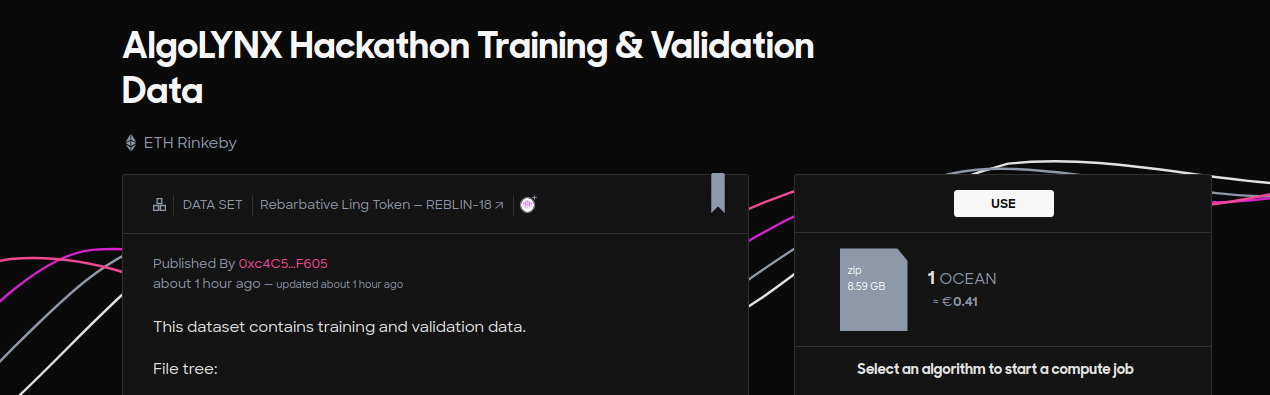

In [3]:
display(Image(filename='images/download-sample.png', width = 800))

# Step 2: Browse the Ocean Marketplace Using the Ocean Python Library

Now lets do the same through the Ocean Python library. We need to connect to the Ethereum network via an Ethereum node. We have set the config parameters for you in a config file. We are currently using [Infura](https://infura.io) for this but will be migrating to a full Ethereum Erigon node asap for increased decentralization. 

In [4]:
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.config import Config

config = Config('config.ini')
ocean = Ocean(config)

print(f"config.network_url = '{config.network_url}'")
print(f"config.metadata_cache_uri = '{config.metadata_cache_uri}'")
print(f"config.provider_url = '{config.provider_url}'")

config.network_url = 'https://rinkeby.infura.io/v3/d163c48816434b0bbb3ac3925d6c6c80'
config.metadata_cache_uri = 'https://aquarius.oceanprotocol.com'
config.provider_url = 'https://provider.rinkeby.oceanprotocol.com'


Next, export your private key from your metamask wallet. We highly recommend doing this with a wallet that has no real tokens in it (only Rinkeby tokens). For more info on private keys, see [this](https://github.com/oceanprotocol/ocean.py/blob/main/READMEs/wallets.md) from the ocean.py documentation: 

*The whole point of crypto wallets is to store private keys. Wallets have various tradeoffs of cost, convienence, and security. For example, hardware wallets tend to be more secure but less convenient and not free. It can also be useful to store private keys locally on your machine, for testing, though only with a small amount of value at stake (keep the risk down). Do not store your private keys on anything public, unless you want your tokens to disappear. For example, don't store your private keys in GitHub or expose them on frontend webpage code.*

With this in mind, you can directly load your private key into the notebook. We use an envvar rather than storing it in code that might be pushed to a repo. We copy this in for a new session (you may need to restart the notebook server). Here's how we export an environmental variable using an example key (replace this with your actual private key.). From your console:

```console
export MY_TEST_KEY=0xaefd8bc8725c4b3d15fbe058d0f58f4d852e8caea2bf68e0f73acb1aeec19baa
```

Now initialize your wallet:

In [5]:
import os
from ocean_lib.web3_internal.wallet import Wallet

wallet = Wallet(ocean.web3, private_key=os.getenv('MY_TEST_KEY'), transaction_timeout=20, block_confirmations=config.block_confirmations)

print(f"public address = '{wallet.address}'")

public address = '0x2338e4e94AEe1817701F65f2c751f7c844b0e43b'


This should print out the public key of your metamask wallet. Check that it matches the one displayed in your metamask. Let's check the balances in our wallet. These should match the amount you received from the faucets (minus any you've since spent).

In [6]:
from ocean_lib.web3_internal.currency import from_wei # wei is the smallest denomination of ether e.g. like cents
from ocean_lib.models.btoken import BToken #BToken is ERC20
OCEAN_token = BToken(ocean.web3, ocean.OCEAN_address)

print(f"ETH balance = '{from_wei(ocean.web3.eth.get_balance(wallet.address))}'")
print(f"OCEAN balance = '{from_wei(OCEAN_token.balanceOf(wallet.address))}'")

ETH balance = '0.575131367443382886'
OCEAN balance = '2727.234669402668293443'


Now let's find the dataset. For the BCI dataset [here](https://market.oceanprotocol.com/asset/did:op:3819B03ADeaBE19e14b8e514544Ba1a6E61ea510), copy the decentralized identifier (DID).  

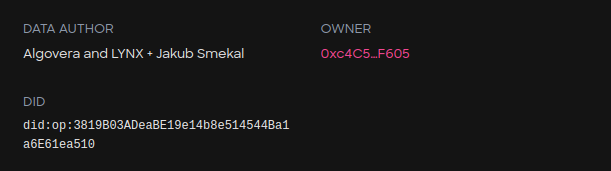

In [7]:
display(Image(filename='images/did.png', width = 400))

In [8]:
did = "did:op:3819B03ADeaBE19e14b8e514544Ba1a6E61ea510"
asset = ocean.assets.resolve(did)

print(f"Data token info = '{asset.values['dataTokenInfo']}'")
print(f"Dataset name = '{asset.metadata['main']['name']}'")

Data token info = '{'address': '0x3819B03ADeaBE19e14b8e514544Ba1a6E61ea510', 'name': 'Rebarbative Ling Token', 'symbol': 'REBLIN-18', 'decimals': 18, 'cap': 1000.0}'
Dataset name = 'AlgoLYNX Hackathon Training & Validation Data'


We can get the URL to the sample data from the associated metadata:

In [9]:
from pathlib import Path
sample_link = asset.metadata['additionalInformation']['links'][0]['url']
dataset_name = Path(sample_link).parts[2]
print(f"Sample link = '{sample_link}'")

Sample link = 'https://bafybeiey4dd775fheouq6ck542s2dinguenapt6rcdc6znuh3xucsasxui.ipfs.dweb.link/sample_data_single_column.zip'


In [10]:
data_dir = Path('data')
sample_dir = data_dir / dataset_name

In [11]:
!mkdir -p {data_dir}

Download the data from the command line:

In [12]:
!wget {sample_link} -O {sample_dir}

--2022-03-11 13:55:53--  https://bafybeiey4dd775fheouq6ck542s2dinguenapt6rcdc6znuh3xucsasxui.ipfs.dweb.link/sample_data_single_column.zip
Resolving bafybeiey4dd775fheouq6ck542s2dinguenapt6rcdc6znuh3xucsasxui.ipfs.dweb.link (bafybeiey4dd775fheouq6ck542s2dinguenapt6rcdc6znuh3xucsasxui.ipfs.dweb.link)... 2602:fea2:2::1, 209.94.90.1
Connecting to bafybeiey4dd775fheouq6ck542s2dinguenapt6rcdc6znuh3xucsasxui.ipfs.dweb.link (bafybeiey4dd775fheouq6ck542s2dinguenapt6rcdc6znuh3xucsasxui.ipfs.dweb.link)|2602:fea2:2::1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6136 (6.0K) [application/zip]
Saving to: ‘data/sample_data_single_column.zip’

data/sample_data_si 100%[===================>]   5.99K  --.-KB/s    in 0s      

2022-03-11 13:55:53 (598 MB/s) - ‘data/sample_data_single_column.zip’ saved [6136/6136]



Now lets inspect the sample data. The data provider should provide this in the same format as the whole dataset. This helps us as data scientists to write scripts that run on both the sample data and the whole dataset. We call this the **interface** of the data. 

In [13]:
import zipfile
with zipfile.ZipFile(sample_dir, 'r') as zip_ref:
    zip_ref.extractall(str(data_dir))

In [14]:
print("Listing files...")
data_path = []
for root, dirs, files in os.walk(data_dir):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))
    for file in files:
        fn = os.path.join(root,file)
        if fn.split('.')[-1] in ['feather']:
            data_path.append(fn)
        print(len(path) * '---', file)

Listing files...
 data
--- sample_data_single_column.zip
--- sample_data_single_column
------ sample_col_memory.feather
------ sample_col_eyesclosed.feather
------ sample_col_music.feather
------ sample_col_mathematic.feather
------ sample_col_eyesopen.feather


In [15]:
import numpy as np
import pandas as pd

In [16]:
print("Reading files...")
datas = []
for path in data_path:
    datas.append(np.array(pd.read_feather(data_path[0])))
data = np.stack(datas)

Reading files...


In [17]:
print("Data shape:", data.shape)

Data shape: (5, 61, 1)


There are 5 different sessions, where participants completed five tasks:

1. Resting-state: eyes open
2. Resting-state: eyes closed
3. Cognitive: subtraction task
4. Cognitive: listening to music
5. Cognitive: memory task. 

We included 61 sensors from the EEG net.

You can find more information about the dataset [here](https://phas3.notion.site/EEG-dataset-details-680893f310d54fcaa85deb8b02f59c03).

The next step is to write some code to run on the sample data before sending it to run on the full dataset. 